##### Copyright 2018 The TensorFlow Authors.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This guide trains a neural network model to classify images of clothing, like sneakers and shirts. It's okay if you don't understand all the details; this is a fast-paced overview of a complete TensorFlow program with the details explained as you go.

This guide uses [tf.keras](https://www.tensorflow.org/guide/keras), a high-level API to build and train models in TensorFlow.

## NoteBook Overview
1. **Loads CIFAR-10 dataset** — small RGB images (32×32 pixels) in 10 classes.

2. **Normalizes data** — rescales image pixel values to [0, 1].

3. **Visualizes the dataset** — using Matplotlib before and after normalization.

4. **Builds a CNN** — with three convolutional layers followed by dense layers.

5. **Trains the model** — using SparseCategoricalCrossentropy and Adam.

6. **Evaluates the model** — shows test accuracy.

7. **Makes Predictions** — uses a softmax wrapper to get probabilities.

8. **Visualizes predictions** — with confidence bars and true vs. predicted labels.

9. **Tests single image predictions** — wraps one image in a batch for inference.



In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import datasets, layers, models

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

    0/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


       0/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

 4202496/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

17448960/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


   0/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


      0/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

4202496/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


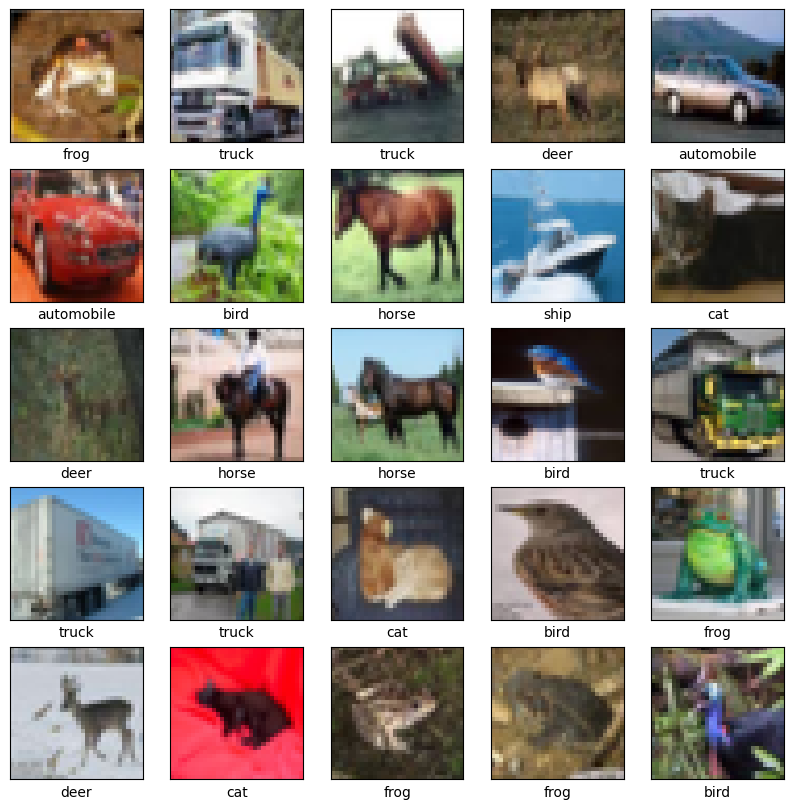

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Explore the data

Let's explore the format of the dataset before training the model. The following shows there are 50,000 images in the training set, with each image represented as 32 x 32 pixels:

In [5]:
train_images.shape

(50000, 32, 32, 3)

Likewise, there are 50,000 labels in the training set:

In [6]:
len(train_labels)

50000

Each label is an integer between 0 and 9:

In [7]:
import pandas as pd
a = pd.DataFrame(train_labels)
a[0].unique()

array([6, 9, 4, 1, 2, 7, 8, 3, 5, 0], dtype=uint8)

There are 10,000 images in the test set. Again, each image is represented as 32 x 32 pixels:

In [8]:
test_images.shape

(10000, 32, 32, 3)

And the test set contains 10,000 images labels:

In [9]:
len(test_labels)

10000

## Preprocess the data

The data must be preprocessed before training the network. If you inspect the first image in the training set, you will see that the pixel values fall in the range of 0 to 255:

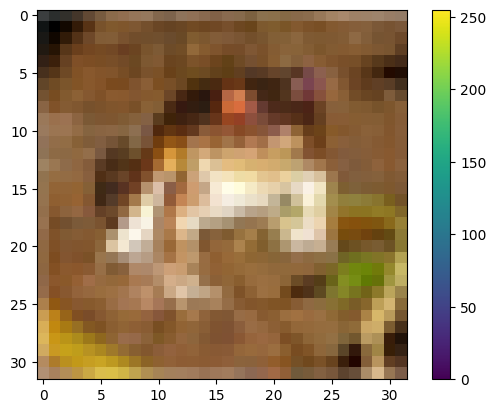

In [10]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Scale these values to a range of 0 to 1 before feeding them to the neural network model. To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [11]:
train_images = train_images / 255.0

test_images = test_images / 255.0

To verify that the data is in the correct format and that you're ready to build and train the network, let's display the first 25 images from the *training set* and display the class name below each image.

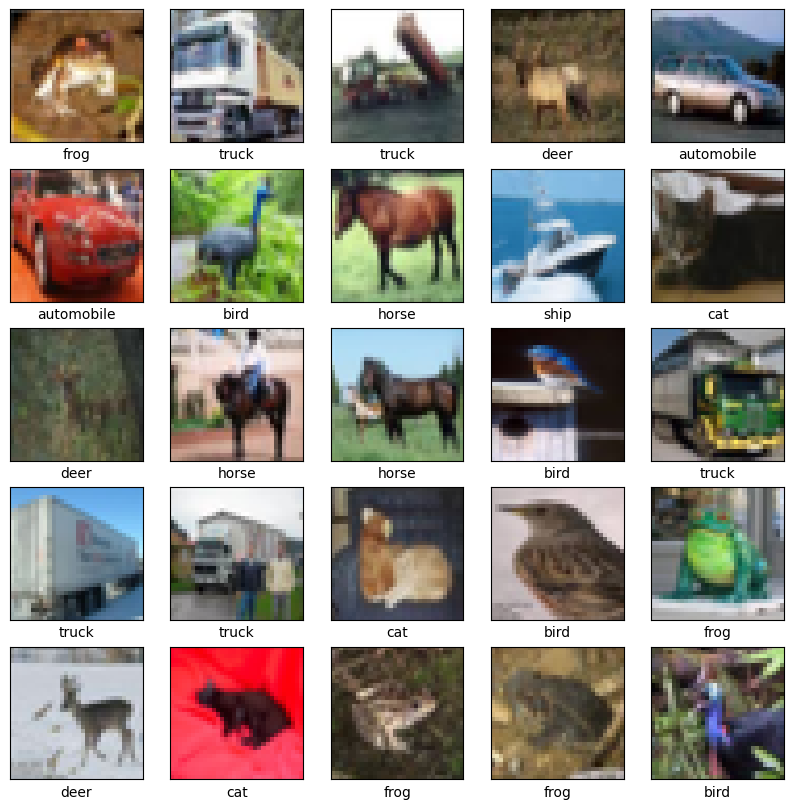

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Build the model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [13]:
model = models.Sequential()
model.add(layers.Input(shape = (32, 32, 3)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=(28, 28)),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(10)
# ])

d negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723771245.425820    8232 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723771245.429273    8232 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723771245.432759    8232 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See mo

The Flatten layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a two-dimensional array (of 32 by 32 pixels) to a one-dimensional array (of 32 * 32 = 640 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are densely connected, or fully connected, neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer returns a logits array with length of 10. Each node contains a score that indicates the current image belongs to one of the 10 classes.

### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's [*compile*](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) step:

* [*Optimizer*](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) —This is how the model is updated based on the data it sees and its loss function.
* [*Loss function*](https://www.tensorflow.org/api_docs/python/tf/keras/losses) —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
* [*Metrics*](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) —Used to monitor the training and testing steps. The following example uses *accuracy*, the fraction of the images that are correctly classified.

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the `train_images` and `train_labels` arrays.
2. The model learns to associate images and labels.
3. You ask the model to make predictions about a test set—in this example, the `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.


In [16]:
history = model.fit(train_images, train_labels, epochs=15, 
                    validation_data=(test_images, test_labels))

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.3522 - loss: 1.7662 - val_accuracy: 0.5335 - val_loss: 1.3118
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 34s 22ms/step - accuracy: 0.5707 - loss: 1.2058 - val_accuracy: 0.6196 - val_loss: 1.0757
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - accuracy: 0.6413 - loss: 1.0227 - val_accuracy: 0.6549 - val_loss: 0.9876
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.6781 - loss: 0.9262 - val_accuracy: 0.6656 - val_loss: 0.9495
Epoch 5/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.7031 - loss: 0.8472 - val_accuracy: 0.6770 - val_loss: 0.9302
Epoch 6/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.7240 - loss: 0.7890 - val_accuracy: 0.6891 - val_loss: 0.8991
Epoch 7/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.7410 - loss: 0.7384 - val_accuracy: 0.6928 - val_loss: 0.9017
Epoch 8/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.7537 -

  94/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1576 - loss: 2.2336

 118/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1661 - loss: 2.2111

 143/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1747 - loss: 2.1888

 167/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1824 - loss: 2.1690

 192/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1899 - loss: 2.1491

 217/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1966 - loss: 2.1313

 241/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2027 - loss: 2.1155

 266/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2089 - loss: 2.0999

 291/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2148 - loss: 2.0849

 316/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2206 - loss: 2.0704

 341/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2260 - loss: 2.0564

 366/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2313 - loss: 2.0432

 391/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2362 - loss: 2.0307

 416/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2409 - loss: 2.0189

 442/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2455 - loss: 2.0074

 467/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2498 - loss: 1.9967

 493/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2541 - loss: 1.9861

 519/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2584 - loss: 1.9760

 544/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2623 - loss: 1.9665

 569/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2660 - loss: 1.9576

 594/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2696 - loss: 1.9489

 618/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2730 - loss: 1.9408

 643/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2764 - loss: 1.9327

 667/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2795 - loss: 1.9250

 692/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2827 - loss: 1.9174

 716/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2856 - loss: 1.9103

 740/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2884 - loss: 1.9034

 765/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2913 - loss: 1.8964

 790/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2941 - loss: 1.8895

 814/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2967 - loss: 1.8831

 839/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2994 - loss: 1.8765

 864/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3020 - loss: 1.8701

 888/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3045 - loss: 1.8641

 912/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3069 - loss: 1.8582

 936/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3093 - loss: 1.8525

 961/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3117 - loss: 1.8467

 985/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3140 - loss: 1.8412

1009/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3162 - loss: 1.8359

1032/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3182 - loss: 1.8310

1056/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3203 - loss: 1.8259

1080/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3224 - loss: 1.8209

1103/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3244 - loss: 1.8163

1127/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3263 - loss: 1.8115

1152/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3284 - loss: 1.8066

1177/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3304 - loss: 1.8018

1202/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3323 - loss: 1.7971

1227/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3343 - loss: 1.7924

1252/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3361 - loss: 1.7879

1277/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3380 - loss: 1.7835

1302/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3398 - loss: 1.7791

1326/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3415 - loss: 1.7750

1350/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3432 - loss: 1.7710

1374/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3448 - loss: 1.7670

1398/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3464 - loss: 1.7631

1423/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3481 - loss: 1.7591

1448/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3497 - loss: 1.7552

1473/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3513 - loss: 1.7513

1498/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3529 - loss: 1.7475

1523/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3544 - loss: 1.7438

1547/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3559 - loss: 1.7402

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3569 - loss: 1.7378

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.3569 - loss: 1.7377 - val_accuracy: 0.5424 - val_loss: 1.2687


Epoch 2/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:17 50ms/step - accuracy: 0.4688 - loss: 1.1854

  26/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5545 - loss: 1.1772   

  50/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5560 - loss: 1.1920

  74/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5554 - loss: 1.1979

 100/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5543 - loss: 1.2050

 125/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5541 - loss: 1.2086

 151/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5536 - loss: 1.2140

 177/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5536 - loss: 1.2175

 201/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5533 - loss: 1.2205

 226/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5528 - loss: 1.2234

 251/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5527 - loss: 1.2249

 276/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5530 - loss: 1.2257

 301/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5533 - loss: 1.2261

 326/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5537 - loss: 1.2263

 351/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5542 - loss: 1.2261

 376/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5547 - loss: 1.2257

 401/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5553 - loss: 1.2251

 426/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5558 - loss: 1.2247

 451/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5563 - loss: 1.2242

 476/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5567 - loss: 1.2237

 501/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5572 - loss: 1.2232

 526/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5576 - loss: 1.2227

 551/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5580 - loss: 1.2222

 575/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5585 - loss: 1.2216

 600/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5589 - loss: 1.2209

 625/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5594 - loss: 1.2202

 650/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5599 - loss: 1.2194

 676/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5604 - loss: 1.2186

 701/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5608 - loss: 1.2180

 726/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5612 - loss: 1.2173

 750/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5615 - loss: 1.2167

 774/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5619 - loss: 1.2162

 799/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5623 - loss: 1.2156

 823/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5626 - loss: 1.2151

 848/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5630 - loss: 1.2145

 872/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5633 - loss: 1.2139

 897/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5637 - loss: 1.2133

 922/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5640 - loss: 1.2126

 946/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5644 - loss: 1.2120

 971/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5647 - loss: 1.2113

 996/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5651 - loss: 1.2107

1021/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5654 - loss: 1.2100

1046/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5658 - loss: 1.2094

1071/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5661 - loss: 1.2087

1096/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: 1.2080

1120/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5668 - loss: 1.2074

1144/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5671 - loss: 1.2068

1169/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5675 - loss: 1.2062

1194/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5678 - loss: 1.2055

1219/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5681 - loss: 1.2049

1244/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5684 - loss: 1.2042

1268/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5687 - loss: 1.2036

1293/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5690 - loss: 1.2030

1318/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5693 - loss: 1.2024

1342/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5696 - loss: 1.2018

1366/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5699 - loss: 1.2013

1391/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5702 - loss: 1.2007

1416/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5705 - loss: 1.2001

1440/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5707 - loss: 1.1995

1465/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5710 - loss: 1.1990

1490/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5713 - loss: 1.1984

1514/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5716 - loss: 1.1978

1538/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5718 - loss: 1.1972

1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5721 - loss: 1.1966

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5721 - loss: 1.1966 - val_accuracy: 0.5967 - val_loss: 1.1490


Epoch 3/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:12 46ms/step - accuracy: 0.8125 - loss: 0.6786

  24/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6838 - loss: 0.9586   

  47/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6592 - loss: 1.0065

  70/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6483 - loss: 1.0209

  92/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6415 - loss: 1.0309

 115/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6383 - loss: 1.0345

 138/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6364 - loss: 1.0354

 160/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6356 - loss: 1.0355

 183/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6348 - loss: 1.0362

 206/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6338 - loss: 1.0378

 229/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6331 - loss: 1.0387

 252/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6328 - loss: 1.0387

 275/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6325 - loss: 1.0386

 299/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6324 - loss: 1.0386

 323/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6323 - loss: 1.0389

 346/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6323 - loss: 1.0389

 370/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6323 - loss: 1.0391

 394/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6322 - loss: 1.0394

 418/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6323 - loss: 1.0394

 441/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6324 - loss: 1.0393

 465/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6326 - loss: 1.0389

 489/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6329 - loss: 1.0385

 512/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6331 - loss: 1.0380

 536/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6332 - loss: 1.0376

 559/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6334 - loss: 1.0370

 583/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6337 - loss: 1.0364

 607/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6339 - loss: 1.0359

 630/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6341 - loss: 1.0354

 654/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6343 - loss: 1.0349

 678/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6345 - loss: 1.0345

 702/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6347 - loss: 1.0340

 726/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6349 - loss: 1.0336

 750/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6351 - loss: 1.0331

 774/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6353 - loss: 1.0327

 798/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6355 - loss: 1.0323

 822/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6356 - loss: 1.0319

 846/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6358 - loss: 1.0316

 870/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6360 - loss: 1.0312

 893/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6361 - loss: 1.0309

 917/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6362 - loss: 1.0306

 941/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6364 - loss: 1.0303

 965/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6365 - loss: 1.0300

 989/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6367 - loss: 1.0297

1013/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6368 - loss: 1.0294

1037/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6369 - loss: 1.0292

1061/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6370 - loss: 1.0289

1085/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6371 - loss: 1.0287

1109/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6373 - loss: 1.0284

1133/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6374 - loss: 1.0281

1157/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 1.0278

1180/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6376 - loss: 1.0275

1204/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6377 - loss: 1.0272

1228/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6378 - loss: 1.0269

1251/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6379 - loss: 1.0267

1275/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6380 - loss: 1.0264

1299/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6381 - loss: 1.0262

1322/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6382 - loss: 1.0260

1345/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6382 - loss: 1.0258

1369/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6383 - loss: 1.0256

1393/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - loss: 1.0254

1416/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6385 - loss: 1.0252

1439/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6385 - loss: 1.0250

1463/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6386 - loss: 1.0248

1486/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6387 - loss: 1.0246

1510/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6387 - loss: 1.0244

1534/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6388 - loss: 1.0242

1558/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6389 - loss: 1.0240

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6389 - loss: 1.0240 - val_accuracy: 0.6467 - val_loss: 0.9909


Epoch 4/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:15 48ms/step - accuracy: 0.5938 - loss: 1.2151

  23/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6706 - loss: 0.9344   

  45/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6723 - loss: 0.9242

  67/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6708 - loss: 0.9287

  89/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6697 - loss: 0.9329

 111/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6697 - loss: 0.9331

 133/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6699 - loss: 0.9335

 155/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6702 - loss: 0.9330

 177/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6709 - loss: 0.9315

 199/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6716 - loss: 0.9300

 221/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6724 - loss: 0.9284

 243/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6732 - loss: 0.9266

 265/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6736 - loss: 0.9256

 287/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6737 - loss: 0.9251

 309/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6739 - loss: 0.9245

 331/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6741 - loss: 0.9239

 353/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6743 - loss: 0.9234

 376/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6745 - loss: 0.9227

 399/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6748 - loss: 0.9220

 422/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6749 - loss: 0.9214

 445/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6751 - loss: 0.9209

 469/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6752 - loss: 0.9204

 493/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6753 - loss: 0.9200

 516/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6754 - loss: 0.9197

 539/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6754 - loss: 0.9195

 562/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6754 - loss: 0.9194

 586/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6753 - loss: 0.9194

 610/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6752 - loss: 0.9195

 634/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6752 - loss: 0.9195

 657/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6752 - loss: 0.9195

 680/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6752 - loss: 0.9195

 703/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6752 - loss: 0.9195

 726/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6752 - loss: 0.9194

 749/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6752 - loss: 0.9193

 773/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6752 - loss: 0.9192

 797/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6752 - loss: 0.9191

 821/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6753 - loss: 0.9189

 844/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6754 - loss: 0.9187

 868/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6754 - loss: 0.9185

 892/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6755 - loss: 0.9182

 915/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6755 - loss: 0.9180

 938/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6756 - loss: 0.9178

 961/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6756 - loss: 0.9176

 984/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6757 - loss: 0.9175

1007/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6757 - loss: 0.9173

1030/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6758 - loss: 0.9172

1054/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6758 - loss: 0.9171

1077/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6758 - loss: 0.9170

1100/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6758 - loss: 0.9168

1124/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.9167

1147/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.9167

1170/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.9166

1194/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.9165

1218/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6759 - loss: 0.9165

1242/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.9164

1265/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.9164

1288/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.9164

1311/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6760 - loss: 0.9164

1333/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.9163

1356/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.9163

1379/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.9163

1403/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6761 - loss: 0.9163

1427/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - loss: 0.9162

1450/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6762 - loss: 0.9162

1473/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.9161

1496/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6763 - loss: 0.9160

1519/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6764 - loss: 0.9160

1543/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6764 - loss: 0.9159

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6764 - loss: 0.9159 - val_accuracy: 0.6715 - val_loss: 0.9493


Epoch 5/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:13 47ms/step - accuracy: 0.5938 - loss: 0.9861

  23/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6677 - loss: 0.9050   

  44/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6748 - loss: 0.8918

  66/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6757 - loss: 0.8906

  88/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6782 - loss: 0.8853

 109/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6810 - loss: 0.8805

 130/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6828 - loss: 0.8780

 152/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6836 - loss: 0.8777

 174/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6834 - loss: 0.8788

 196/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6837 - loss: 0.8793

 218/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6841 - loss: 0.8791

 240/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6847 - loss: 0.8784

 262/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6851 - loss: 0.8775

 284/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6857 - loss: 0.8763

 307/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6864 - loss: 0.8750

 330/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6870 - loss: 0.8737

 353/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6875 - loss: 0.8728

 376/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6880 - loss: 0.8720

 399/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6885 - loss: 0.8710

 422/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6889 - loss: 0.8701

 444/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6893 - loss: 0.8692

 466/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6897 - loss: 0.8684

 489/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6901 - loss: 0.8676

 511/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6905 - loss: 0.8670

 534/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6908 - loss: 0.8662

 557/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6912 - loss: 0.8655

 579/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6915 - loss: 0.8650

 602/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6918 - loss: 0.8645

 624/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6921 - loss: 0.8641

 647/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6923 - loss: 0.8637

 670/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6926 - loss: 0.8633

 693/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6928 - loss: 0.8629

 716/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6931 - loss: 0.8625

 740/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6933 - loss: 0.8621

 763/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6935 - loss: 0.8616

 787/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6938 - loss: 0.8612

 810/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6940 - loss: 0.8608

 834/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6943 - loss: 0.8603

 858/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6945 - loss: 0.8598

 882/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6947 - loss: 0.8594

 905/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6949 - loss: 0.8590

 928/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6951 - loss: 0.8587

 950/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6953 - loss: 0.8583

 973/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6955 - loss: 0.8579

 996/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6957 - loss: 0.8575

1020/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6958 - loss: 0.8571

1044/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6960 - loss: 0.8566

1068/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6962 - loss: 0.8562

1092/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6964 - loss: 0.8558

1116/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6966 - loss: 0.8554

1140/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6967 - loss: 0.8550

1163/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6969 - loss: 0.8547

1187/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6970 - loss: 0.8544

1211/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6972 - loss: 0.8541

1235/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6973 - loss: 0.8539

1259/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6974 - loss: 0.8536

1283/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6976 - loss: 0.8533

1307/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6977 - loss: 0.8530

1331/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6978 - loss: 0.8528

1355/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6979 - loss: 0.8525

1379/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6981 - loss: 0.8523

1403/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6982 - loss: 0.8520

1427/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 0.8518

1451/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6984 - loss: 0.8515

1475/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6985 - loss: 0.8513

1499/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6986 - loss: 0.8511

1523/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6988 - loss: 0.8509

1547/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6989 - loss: 0.8507

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6989 - loss: 0.8506 - val_accuracy: 0.6999 - val_loss: 0.8737


Epoch 6/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:13 47ms/step - accuracy: 0.6250 - loss: 0.8435

  24/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6897 - loss: 0.8113   

  48/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7101 - loss: 0.7816

  73/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7198 - loss: 0.7702

  97/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7223 - loss: 0.7697

 121/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7237 - loss: 0.7687

 146/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7246 - loss: 0.7687

 170/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7251 - loss: 0.7687

 194/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7253 - loss: 0.7694

 218/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7255 - loss: 0.7701

 242/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7254 - loss: 0.7715

 266/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7253 - loss: 0.7732

 290/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7255 - loss: 0.7743

 314/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7257 - loss: 0.7750

 338/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7258 - loss: 0.7757

 363/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7260 - loss: 0.7767

 387/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7260 - loss: 0.7777

 412/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7261 - loss: 0.7787

 436/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7262 - loss: 0.7793

 461/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7263 - loss: 0.7798

 485/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7263 - loss: 0.7802

 510/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7264 - loss: 0.7805

 535/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7266 - loss: 0.7807

 559/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7267 - loss: 0.7809

 583/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7268 - loss: 0.7810

 607/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7269 - loss: 0.7811

 632/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7271 - loss: 0.7811

 657/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7272 - loss: 0.7810

 682/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7273 - loss: 0.7810

 707/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7274 - loss: 0.7809

 732/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7276 - loss: 0.7807

 757/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7277 - loss: 0.7806

 782/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7278 - loss: 0.7805

 806/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7278 - loss: 0.7804

 831/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

 856/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

 881/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

 905/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

 929/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

 954/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

 979/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

1004/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7803

1029/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

1053/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

1078/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7279 - loss: 0.7804

1103/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.7805

1128/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.7806

1152/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7278 - loss: 0.7806

1177/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7807

1201/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7807

1226/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7807

1251/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7807

1276/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7808

1301/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7277 - loss: 0.7808

1325/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7808

1350/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7809

1375/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7809

1399/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7809

1424/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7809

1449/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7809

1474/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7276 - loss: 0.7810

1499/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.7810

1524/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.7810

1549/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7275 - loss: 0.7811

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7275 - loss: 0.7811 - val_accuracy: 0.7032 - val_loss: 0.8687


Epoch 7/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:15 48ms/step - accuracy: 0.7188 - loss: 0.6011

  24/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7582 - loss: 0.6368   

  47/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7508 - loss: 0.6678

  70/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7499 - loss: 0.6820

  93/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7489 - loss: 0.6915

 117/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7496 - loss: 0.6933

 140/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7509 - loss: 0.6927

 163/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7518 - loss: 0.6931

 186/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7526 - loss: 0.6934

 210/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7532 - loss: 0.6937

 233/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7537 - loss: 0.6943

 256/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7543 - loss: 0.6942

 279/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7548 - loss: 0.6941

 302/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7550 - loss: 0.6943

 326/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7552 - loss: 0.6945

 350/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7552 - loss: 0.6948

 373/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7552 - loss: 0.6953

 396/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7551 - loss: 0.6958

 419/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7550 - loss: 0.6965

 442/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7548 - loss: 0.6972

 465/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7545 - loss: 0.6980

 488/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7543 - loss: 0.6987

 511/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7540 - loss: 0.6994

 534/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7537 - loss: 0.7001

 557/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7535 - loss: 0.7007

 579/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7532 - loss: 0.7013

 602/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7530 - loss: 0.7018

 625/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7529 - loss: 0.7023

 648/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7527 - loss: 0.7028

 671/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7525 - loss: 0.7033

 694/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7523 - loss: 0.7038

 718/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7522 - loss: 0.7043

 742/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7520 - loss: 0.7048

 765/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7518 - loss: 0.7052

 788/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7517 - loss: 0.7057

 811/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7515 - loss: 0.7061

 834/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7514 - loss: 0.7066

 857/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7512 - loss: 0.7069

 880/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7511 - loss: 0.7073

 904/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7510 - loss: 0.7077

 927/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7509 - loss: 0.7081

 950/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7507 - loss: 0.7084

 973/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7506 - loss: 0.7088

 996/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7504 - loss: 0.7092

1019/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7503 - loss: 0.7095

1042/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7502 - loss: 0.7098

1065/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7501 - loss: 0.7101

1088/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7500 - loss: 0.7104

1111/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7499 - loss: 0.7107

1135/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7497 - loss: 0.7110

1159/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7496 - loss: 0.7113

1183/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7495 - loss: 0.7116

1207/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.7119

1231/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7493 - loss: 0.7122

1255/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7492 - loss: 0.7124

1279/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7491 - loss: 0.7127

1303/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7490 - loss: 0.7130

1327/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7489 - loss: 0.7133

1351/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7488 - loss: 0.7135

1375/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7487 - loss: 0.7138

1399/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7486 - loss: 0.7141

1423/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7485 - loss: 0.7143

1447/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7484 - loss: 0.7146

1472/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7483 - loss: 0.7149

1496/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7482 - loss: 0.7152

1520/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7481 - loss: 0.7155

1545/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7480 - loss: 0.7158

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7479 - loss: 0.7160 - val_accuracy: 0.7088 - val_loss: 0.8571


Epoch 8/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:14 48ms/step - accuracy: 0.7188 - loss: 0.8551

  25/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7536 - loss: 0.7247   

  49/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7609 - loss: 0.6925

  74/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7659 - loss: 0.6765

  99/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7683 - loss: 0.6690

 123/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7697 - loss: 0.6649

 148/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7705 - loss: 0.6625

 172/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7706 - loss: 0.6619

 197/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7708 - loss: 0.6618

 221/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7705 - loss: 0.6624

 246/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7701 - loss: 0.6633

 270/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7697 - loss: 0.6643

 295/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7694 - loss: 0.6648

 319/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7693 - loss: 0.6649

 344/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7691 - loss: 0.6653

 369/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7690 - loss: 0.6658

 394/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7689 - loss: 0.6662

 418/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7689 - loss: 0.6665

 442/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7688 - loss: 0.6668

 467/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7688 - loss: 0.6672

 492/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7686 - loss: 0.6677

 517/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7684 - loss: 0.6680

 542/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7682 - loss: 0.6684

 566/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7681 - loss: 0.6687

 591/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7679 - loss: 0.6691

 616/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7677 - loss: 0.6695

 641/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7675 - loss: 0.6699

 666/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7673 - loss: 0.6702

 691/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7672 - loss: 0.6705

 716/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7671 - loss: 0.6707

 741/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7670 - loss: 0.6710

 766/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7669 - loss: 0.6713

 791/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7668 - loss: 0.6715

 816/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7667 - loss: 0.6717

 841/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7666 - loss: 0.6720

 866/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7664 - loss: 0.6722

 891/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7664 - loss: 0.6724

 916/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7663 - loss: 0.6726

 941/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7662 - loss: 0.6728

 966/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7661 - loss: 0.6730

 991/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7661 - loss: 0.6731

1016/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7660 - loss: 0.6733

1041/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7659 - loss: 0.6734

1066/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7659 - loss: 0.6736

1091/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.6737

1116/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7658 - loss: 0.6738

1141/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.6739

1166/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.6739

1191/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7657 - loss: 0.6740

1216/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.6740

1241/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.6740

1266/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.6741

1291/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7656 - loss: 0.6742

1316/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.6742

1341/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7655 - loss: 0.6743

1366/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7654 - loss: 0.6744

1391/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7654 - loss: 0.6745

1416/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653 - loss: 0.6746

1441/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653 - loss: 0.6747

1466/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7652 - loss: 0.6748

1491/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7652 - loss: 0.6749

1516/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7651 - loss: 0.6750

1541/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7650 - loss: 0.6751

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7650 - loss: 0.6752 - val_accuracy: 0.7035 - val_loss: 0.8852


Epoch 9/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:13 47ms/step - accuracy: 0.7812 - loss: 0.5414

  24/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7874 - loss: 0.6205   

  48/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7879 - loss: 0.6153

  72/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7876 - loss: 0.6167

  95/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7875 - loss: 0.6167

 118/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7867 - loss: 0.6200

 141/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7859 - loss: 0.6224

 165/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7853 - loss: 0.6242

 188/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7845 - loss: 0.6261

 212/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7839 - loss: 0.6271

 235/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7834 - loss: 0.6277

 259/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7830 - loss: 0.6282

 283/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7826 - loss: 0.6287

 306/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7823 - loss: 0.6292

 330/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7820 - loss: 0.6294

 354/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7818 - loss: 0.6295

 378/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7816 - loss: 0.6296

 401/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7814 - loss: 0.6296

 424/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7811 - loss: 0.6298

 447/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7808 - loss: 0.6301

 471/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7805 - loss: 0.6305

 495/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7803 - loss: 0.6307

 518/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7802 - loss: 0.6309

 542/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7801 - loss: 0.6310

 566/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7801 - loss: 0.6311

 589/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7800 - loss: 0.6312

 612/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7800 - loss: 0.6313

 636/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7800 - loss: 0.6314

 660/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7799 - loss: 0.6316

 684/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7799 - loss: 0.6318

 708/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7798 - loss: 0.6319

 732/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7798 - loss: 0.6320

 755/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7798 - loss: 0.6321

 779/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7798 - loss: 0.6321

 803/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7798 - loss: 0.6322

 827/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7797 - loss: 0.6323

 851/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7797 - loss: 0.6325

 874/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7796 - loss: 0.6328

 897/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7795 - loss: 0.6330

 920/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7794 - loss: 0.6333

 943/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7794 - loss: 0.6334

 967/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7793 - loss: 0.6336

 991/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7793 - loss: 0.6338

1015/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7792 - loss: 0.6340

1039/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7791 - loss: 0.6341

1062/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7791 - loss: 0.6343

1086/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7790 - loss: 0.6345

1110/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7790 - loss: 0.6346

1133/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7789 - loss: 0.6348

1156/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7788 - loss: 0.6349

1180/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7788 - loss: 0.6350

1203/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.6352

1227/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7787 - loss: 0.6353

1251/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7786 - loss: 0.6354

1275/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7786 - loss: 0.6356

1299/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.6357

1323/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7785 - loss: 0.6359

1347/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7784 - loss: 0.6360

1371/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7783 - loss: 0.6361

1395/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7783 - loss: 0.6363

1418/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.6364

1441/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.6366

1464/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7782 - loss: 0.6367

1488/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7781 - loss: 0.6368

1512/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7781 - loss: 0.6369

1536/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.6371

1560/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7780 - loss: 0.6372

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7780 - loss: 0.6372 - val_accuracy: 0.7126 - val_loss: 0.8672


Epoch 10/10


   1/1563 ━━━━━━━━━━━━━━━━━━━━ 1:12 47ms/step - accuracy: 0.9062 - loss: 0.3208

  24/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8187 - loss: 0.4975   

  46/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8116 - loss: 0.5203

  68/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8089 - loss: 0.5317

  90/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8076 - loss: 0.5366

 112/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8073 - loss: 0.5397

 135/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8067 - loss: 0.5425

 158/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8061 - loss: 0.5446

 181/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8057 - loss: 0.5466

 203/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8052 - loss: 0.5486

 226/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8048 - loss: 0.5504

 248/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8044 - loss: 0.5523

 271/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8040 - loss: 0.5541

 294/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8037 - loss: 0.5557

 317/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8034 - loss: 0.5571

 339/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8030 - loss: 0.5586

 361/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8027 - loss: 0.5599

 384/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8024 - loss: 0.5612

 406/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8021 - loss: 0.5623

 428/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8018 - loss: 0.5634

 450/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8015 - loss: 0.5645

 472/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8012 - loss: 0.5655

 494/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8010 - loss: 0.5665

 516/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8007 - loss: 0.5676

 539/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8004 - loss: 0.5686

 562/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8001 - loss: 0.5695

 585/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7998 - loss: 0.5703

 608/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7996 - loss: 0.5711

 630/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7994 - loss: 0.5718

 652/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7992 - loss: 0.5725

 674/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7990 - loss: 0.5730

 696/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7988 - loss: 0.5736

 718/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7986 - loss: 0.5741

 740/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7984 - loss: 0.5745

 762/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7982 - loss: 0.5749

 784/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7981 - loss: 0.5752

 806/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7980 - loss: 0.5756

 828/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7979 - loss: 0.5759

 850/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7977 - loss: 0.5763

 872/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7976 - loss: 0.5767

 893/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7975 - loss: 0.5771

 914/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7974 - loss: 0.5774

 936/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7973 - loss: 0.5777

 958/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7972 - loss: 0.5780

 980/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7971 - loss: 0.5784

1002/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7970 - loss: 0.5787

1024/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7969 - loss: 0.5791

1045/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7968 - loss: 0.5794

1066/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7967 - loss: 0.5798

1088/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7966 - loss: 0.5801

1110/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7964 - loss: 0.5805

1132/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.5808

1154/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.5811

1176/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7961 - loss: 0.5814

1198/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.5817

1220/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7959 - loss: 0.5820

1242/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7958 - loss: 0.5823

1264/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7957 - loss: 0.5826

1286/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7956 - loss: 0.5829

1308/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.5832

1330/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.5834

1352/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7954 - loss: 0.5837

1374/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7953 - loss: 0.5840

1396/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7952 - loss: 0.5842

1418/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - loss: 0.5845

1440/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7951 - loss: 0.5847

1462/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7950 - loss: 0.5850

1484/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.5852

1506/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.5855

1528/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7948 - loss: 0.5857

1551/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7947 - loss: 0.5860

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7946 - loss: 0.5862 - val_accuracy: 0.7163 - val_loss: 0.8550


As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.95 (or 95%) on the training data.

### Evaluate accuracy

Next, compare how the model performs on the test dataset:

In [18]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 3s - 9ms/step - accuracy: 0.7073 - loss: 0.9602

Test accuracy: 0.7073000073432922



Test accuracy: 0.8863000273704529


313/313 - 2s - 8ms/step - accuracy: 0.7073 - loss: 0.9602


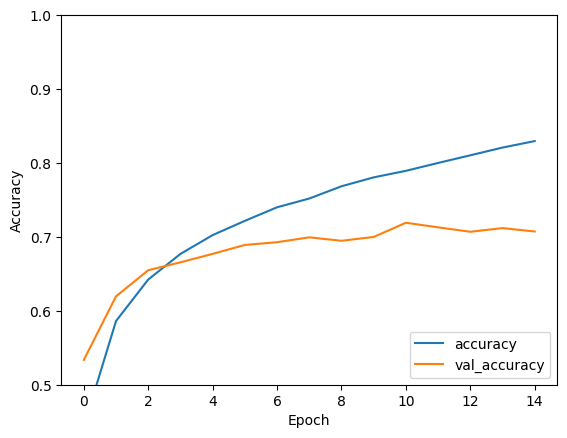

In [42]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. For more information, see the following:
*   [Demonstrate overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#demonstrate_overfitting)
*   [Strategies to prevent overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#strategies_to_prevent_overfitting)

### Make predictions

With the model trained, you can use it to make predictions about some images.
Attach a softmax layer to convert the model's linear outputs—[logits](https://developers.google.com/machine-learning/glossary#logits)—to probabilities, which should be easier to interpret.

In [19]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

In [20]:
predictions = probability_model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step 


 52/313 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step 

104/313 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step

157/313 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step

211/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step

264/313 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [21]:
predictions[0]

array([2.7456939e-05, 2.0998490e-05, 4.5438387e-04, 9.2563224e-01,
       1.7648336e-03, 2.9752342e-02, 1.5851209e-02, 1.4225203e-04,
       2.5918331e-02, 4.3596045e-04], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. You can see which label has the highest confidence value:

In [22]:
np.argmax(predictions[0])

np.int64(3)

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [23]:
test_labels[0]

array([3], dtype=uint8)

Define functions to graph the full set of 10 class predictions.

In [24]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### Verify predictions

With the model trained, you can use it to make predictions about some images.

Let's look at the 0th image, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

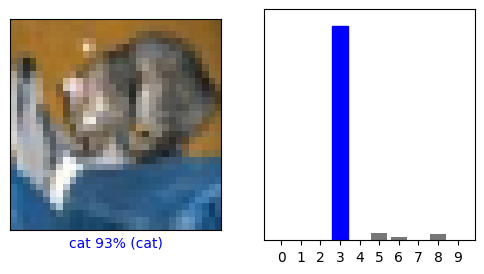

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels[0], test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels[0])
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

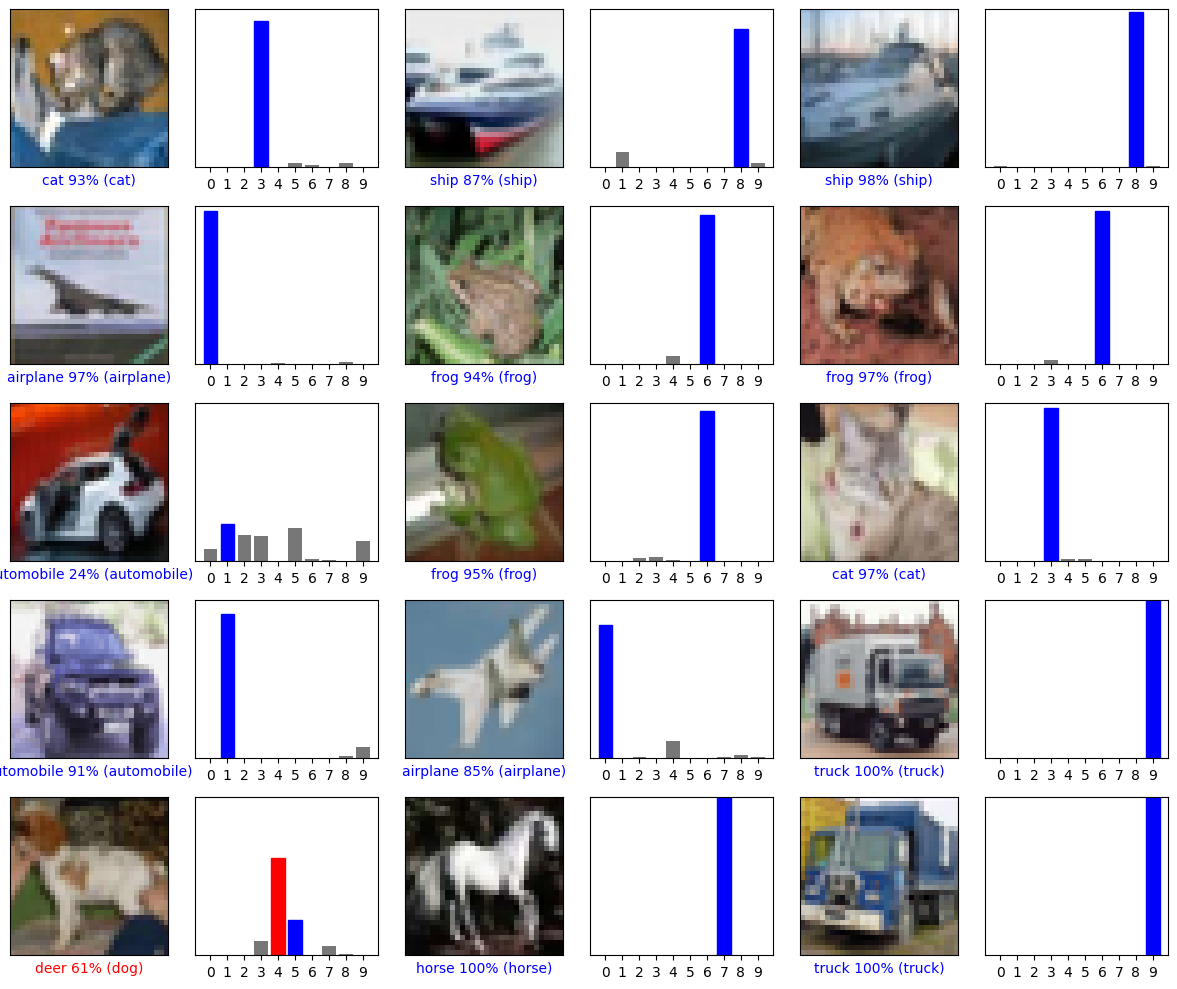

In [28]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i][0], img[i]  # fix here
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  color = 'blue' if predicted_label == true_label else 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(
      class_names[predicted_label],
      100*np.max(predictions_array),
      class_names[true_label]),
      color=color)
def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i][0]  # fix here
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  bar_plot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  bar_plot[predicted_label].set_color('red')
  bar_plot[true_label].set_color('blue')




# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

## Use the trained model

Finally, use the trained model to make a prediction about a single image.

In [29]:
# Grab an image from the test dataset.
img = test_images[1]

print(img.shape)

(32, 32, 3)


`tf.keras` models are optimized to make predictions on a *batch*, or collection, of examples at once. Accordingly, even though you're using a single image, you need to add it to a list:

In [30]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 32, 32, 3)


Now predict the correct label for this image:

In [31]:
predictions_single = probability_model.predict(img)

print(predictions_single)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
[[2.5655199e-03 9.8323487e-02 2.6034388e-09 3.2550421e-08 1.3226360e-10
  1.4159936e-10 1.7137431e-08 1.5859565e-07 8.7140822e-01 2.7702592e-02]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


[[4.0262650e-05 1.7603366e-12 9.9607229e-01 4.6822952e-11 3.8338848e-03
  1.7586101e-10 5.3584125e-05 7.4621548e-13 5.4244734e-12 5.0442324e-15]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


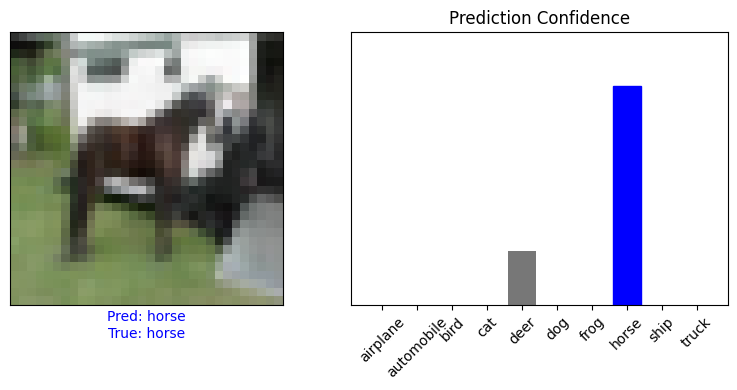

In [41]:
# Get the image and prediction
img = test_images[20]
label = test_labels[20][0]  # extract scalar from array
img_batch = np.expand_dims(img, 0)
predictions_single = probability_model.predict(img_batch)

# Create subplots
plt.figure(figsize=(8,4))

# Left: image
plt.subplot(1, 2, 1)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(img, cmap=plt.cm.binary)
pred_label = np.argmax(predictions_single[0])
color = 'blue' if pred_label == label else 'red'
plt.xlabel(f"Pred: {class_names[pred_label]}\nTrue: {class_names[label]}", color=color)

# Right: softmax bar chart
plt.subplot(1, 2, 2)
plt.grid(False)
plt.xticks(range(10), class_names, rotation=45)
plt.yticks([])
bar_plot = plt.bar(range(10), predictions_single[0], color="#777777")
plt.ylim([0, 1])
bar_plot[pred_label].set_color('red')
bar_plot[label].set_color('blue')
plt.title("Prediction Confidence")

plt.tight_layout()
plt.show()

`tf.keras.Model.predict` returns a list of lists—one list for each image in the batch of data. Grab the predictions for our (only) image in the batch:

In [33]:
np.argmax(predictions_single[0])

np.int64(8)

And the model predicts a label as expected.

To learn more about building models with Keras, see the [Keras guides](https://www.tensorflow.org/guide/keras).